# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_121  P13521            19.847
Sample_069  P01859            24.006
Sample_125  Q9H492;Q9H492-2   13.054
Sample_031  P10586;P10586-2   18.077
Sample_074  O00451            14.798
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                      
Sample_023  B7ZKJ8                                 14.820
Sample_174  Q15847                                 14.343
Sample_050  E9PMI0;E9PQU7;E9PR90;Q6UX15;Q6UX15-2   15.722
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.029
            A0A075B6Q5                 12.729
            A0A075B6R2                 13.240
            A0A075B6S5                 13.089
            A0A087WSY4                 12.549
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.303
            Q9UI40;Q9UI40-2            12.370
            Q9UIW2                     12.320
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.279
            Q9UP79                     12.332
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.075,15.050,16.842,19.863,15.898,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.784,19.067,...,15.528,15.576,14.105,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.836,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.584,17.705,17.039,15.999,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.822,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.311,15.345,17.084,18.708,14.249,19.433,11.476,11.116
Sample_207,15.739,16.877,15.469,16.898,14.779,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.054,12.255,11.975,13.242,11.883,13.109,11.153,13.294,12.777,13.124
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.754,19.067,16.127,...,12.993,12.217,12.190,11.369,13.545,13.614,12.049,11.676,11.374,13.771
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.242,13.906,11.957,12.867,13.374,12.227,12.045,13.249,13.792,14.399
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.725,12.958,13.615,13.356,13.480,11.386,11.900,13.273,13.367,12.579
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.175,12.398,13.391,12.014,14.957,13.042,12.038,13.502,13.676,12.916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.365,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 420.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.98it/s]

100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

100%|██████████| 4/4 [00:00<00:00,  3.85it/s]

100%|██████████| 4/4 [00:00<00:00,  4.21it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.10it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.61it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.73it/s]

100%|██████████| 5/5 [00:00<00:00,  5.38it/s]

100%|██████████| 5/5 [00:00<00:00,  5.87it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.17it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.76it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.03it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.22it/s]

100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

100%|██████████| 6/6 [00:01<00:00,  4.51it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.38it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.30it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.26it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.93it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.75it/s]

100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.22it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.00it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.78it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.21it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.00it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.98it/s]

100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

100%|██████████| 8/8 [00:02<00:00,  3.47it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.56it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.21it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.57it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.83it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.42it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.34it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.34it/s]

100%|██████████| 9/9 [00:01<00:00,  4.38it/s]

100%|██████████| 9/9 [00:01<00:00,  4.77it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.22it/s]

 30%|███       | 3/10 [00:00<00:01,  5.79it/s]

 40%|████      | 4/10 [00:00<00:01,  4.36it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.16it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.16it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.09it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.98it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.13it/s]

100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.91it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.30it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.79it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.43it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.33it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.49it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.51it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.41it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.46it/s]

100%|██████████| 11/11 [00:02<00:00,  4.41it/s]

100%|██████████| 11/11 [00:02<00:00,  4.67it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.31it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.66it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.09it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.77it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.60it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.57it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.48it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.61it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.42it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.84it/s]

100%|██████████| 12/12 [00:02<00:00,  3.39it/s]

100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.77it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.56it/s]

 31%|███       | 4/13 [00:00<00:01,  5.16it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.94it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.64it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.47it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.41it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.61it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.38it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.24it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.30it/s]

100%|██████████| 13/13 [00:02<00:00,  3.68it/s]

100%|██████████| 13/13 [00:02<00:00,  4.44it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.92it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.75it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.56it/s]

 36%|███▌      | 5/14 [00:01<00:01,  4.55it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.51it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.26it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.42it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.35it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.40it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.99it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.87it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.75it/s]

100%|██████████| 14/14 [00:03<00:00,  3.41it/s]

100%|██████████| 14/14 [00:03<00:00,  4.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.25it/s]

 20%|██        | 3/15 [00:00<00:01,  6.20it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.34it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.94it/s]

 40%|████      | 6/15 [00:01<00:01,  4.62it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.62it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.59it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.44it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.39it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.24it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.75it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  3.89it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.93it/s]

100%|██████████| 15/15 [00:03<00:00,  3.27it/s]

100%|██████████| 15/15 [00:03<00:00,  4.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.048 0.022          0.788 0.316       0.134   
2             0.006 0.006      0.061 0.024          0.648 0.137       0.534   
3             0.004 0.003      0.047 0.018          0.730 0.105       0.640   
4             0.006 0.006      0.055 0.021          0.771 0.091       0.680   
5             0.008 0.008      0.065 0.023          0.719 0.082       0.682   
6             0.005 0.004      0.059 0.022          0.741 0.088       0.740   
7             0.005 0.004      0.052 0.020          0.735 0.088       0.735   
8             0.006 0.005      0.057 0.024          0.818 0.078       0.824   
9             0.004 0.003      0.048 0.016          0.822 0.073       0.810   
10            0.005 0.004      0.051 0.025          0.805 0.086       0.820   
11            0.005 0.004      0.055 0.025          0.820 0.084       0.828   
12            0.004 0.005      0.047 0.020          0.823 0.081       0.823   
13            0.005 0.004      0.051 0.020          0.821 0.083       0.824   
14            0.006 0.005      0.050 0.017          0.824 0.077       0.828   
15            0.005 0.003      0.043 0.016          0.823 0.077       0.829   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.091   0.220 0.134                  0.559 0.044        0.857   
2          0.142   0.574 0.117                  0.656 0.080        0.731   
3          0.118   0.675 0.093                  0.731 0.068        0.786   
4          0.114   0.716 0.084                  0.765 0.063        0.818   
5          0.095   0.696 0.072                  0.743 0.058        0.865   
6          0.113   0.735 0.079                  0.773 0.065        0.876   
7          0.111   0.730 0.079                  0.769 0.066        0.874   
8          0.099   0.817 0.068                  0.843 0.056        0.917   
9          0.101   0.811 0.065                  0.839 0.053        0.916   
10         0.106   0.808 0.078                  0.835 0.067        0.916   
11         0.101   0.821 0.078                  0.847 0.067        0.920   
12         0.102   0.820 0.076                  0.846 0.064        0.920   
13         0.100   0.819 0.074                  0.845 0.063        0.919   
14         0.104   0.822 0.073                  0.848 0.062        0.918   
15         0.105   0.822 0.072                  0.848 0.062        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.830 0.092        210.000 0.000  
2          0.087                  0.679 0.098        210.000 0.000  
3          0.065                  0.737 0.086        210.000 0.000  
4          0.065                  0.787 0.092        210.000 0.000  
5          0.053                  0.844 0.060        210.000 0.000  
6          0.052                  0.842 0.065        210.000 0.000  
7          0.052                  0.840 0.065        210.000 0.000  
8          0.044                  0.907 0.045        210.000 0.000  
9          0.044                  0.906 0.046        210.000 0.000  
10         0.046                  0.905 0.048        210.000 0.000  
11         0.046                  0.907 0.048        210.000 0.000  
12         0.046                  0.903 0.051        210.000 0.000  
13         0.046                  0.903 0.051        210.000 0.000  
14         0.046                  0.901 0.052        210.000 0.000  
15         0.046                  0.900 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 478.04it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.03it/s]

100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.99it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.54it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.11it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.46it/s]

100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

100%|██████████| 5/5 [00:01<00:00,  4.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.26it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.88it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.93it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.15it/s]

100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

100%|██████████| 6/6 [00:01<00:00,  4.11it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.28it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.30it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.06it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.26it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.01it/s]

100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.27it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.53it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.68it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.61it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.10it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  2.89it/s]

100%|██████████| 8/8 [00:02<00:00,  2.83it/s]

100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.28it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.76it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.07it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.85it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.71it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.58it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.56it/s]

100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.65it/s]

 30%|███       | 3/10 [00:00<00:01,  5.39it/s]

 40%|████      | 4/10 [00:00<00:01,  4.67it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.43it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.03it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.97it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.84it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.21it/s]

100%|██████████| 10/10 [00:02<00:00,  2.72it/s]

100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.22it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.22it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.97it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.93it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.04it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.20it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.25it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.36it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.47it/s]

100%|██████████| 11/11 [00:03<00:00,  3.33it/s]

100%|██████████| 11/11 [00:03<00:00,  3.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.83it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.52it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.08it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.99it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.65it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.74it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.81it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.87it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.46it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.21it/s]

100%|██████████| 12/12 [00:03<00:00,  2.99it/s]

100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.10it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.38it/s]

 31%|███       | 4/13 [00:01<00:03,  2.93it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.74it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.53it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.74it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.91it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.11it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.15it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.11it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.22it/s]

100%|██████████| 13/13 [00:04<00:00,  3.35it/s]

100%|██████████| 13/13 [00:04<00:00,  3.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.02it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.86it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.68it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.04it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.03it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.04it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.09it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.27it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.29it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.39it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.43it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.51it/s]

100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

100%|██████████| 14/14 [00:04<00:00,  3.28it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.93it/s]

 20%|██        | 3/15 [00:00<00:03,  3.88it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.81it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.67it/s]

 40%|████      | 6/15 [00:01<00:02,  3.56it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.96it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.67it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.64it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.67it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.63it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.71it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.79it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.95it/s]

100%|██████████| 15/15 [00:04<00:00,  3.00it/s]

100%|██████████| 15/15 [00:04<00:00,  3.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.043 0.015          0.000 0.000       0.000   
2             0.005 0.007      0.047 0.019          0.203 0.369       0.020   
3             0.007 0.007      0.057 0.024          0.720 0.102       0.630   
4             0.006 0.005      0.057 0.021          0.750 0.098       0.636   
5             0.004 0.004      0.049 0.020          0.771 0.109       0.683   
6             0.004 0.004      0.042 0.016          0.769 0.107       0.692   
7             0.003 0.000      0.041 0.013          0.794 0.089       0.771   
8             0.004 0.002      0.039 0.014          0.793 0.085       0.767   
9             0.004 0.003      0.050 0.021          0.817 0.084       0.776   
10            0.006 0.005      0.055 0.023          0.809 0.096       0.783   
11            0.005 0.003      0.057 0.023          0.819 0.098       0.782   
12            0.006 0.006      0.054 0.021          0.817 0.096       0.794   
13            0.005 0.005      0.052 0.024          0.826 0.093       0.803   
14            0.007 0.006      0.066 0.023          0.819 0.100       0.793   
15            0.004 0.002      0.038 0.012          0.816 0.100       0.786   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.860   
2          0.036   0.035 0.063                  0.505 0.016        0.810   
3          0.091   0.666 0.071                  0.722 0.057        0.817   
4          0.091   0.684 0.073                  0.738 0.058        0.824   
5          0.102   0.719 0.083                  0.765 0.066        0.834   
6          0.105   0.723 0.082                  0.767 0.066        0.833   
7          0.114   0.775 0.071                  0.809 0.058        0.893   
8          0.117   0.773 0.072                  0.808 0.058        0.890   
9          0.102   0.791 0.069                  0.823 0.057        0.890   
10         0.119   0.790 0.085                  0.822 0.069        0.910   
11         0.126   0.793 0.089                  0.826 0.073        0.910   
12         0.127   0.799 0.089                  0.830 0.073        0.916   
13         0.119   0.809 0.086                  0.838 0.071        0.917   
14         0.122   0.799 0.088                  0.830 0.073        0.916   
15         0.119   0.795 0.087                  0.826 0.073        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.088        210.000 0.000  
2          0.110                  0.774 0.124        210.000 0.000  
3          0.062                  0.785 0.076        210.000 0.000  
4          0.061                  0.790 0.071        210.000 0.000  
5          0.062                  0.798 0.076        210.000 0.000  
6          0.061                  0.794 0.075        210.000 0.000  
7          0.048                  0.864 0.062        210.000 0.000  
8          0.048                  0.861 0.063        210.000 0.000  
9          0.050                  0.862 0.066        210.000 0.000  
10         0.047                  0.879 0.062        210.000 0.000  
11         0.048                  0.880 0.062        210.000 0.000  
12         0.046                  0.890 0.057        210.000 0.000  
13         0.046                  0.893 0.055        210.000 0.000  
14         0.046                  0.894 0.053        210.000 0.000  
15         0.046                  0.894 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1185.50it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.05it/s]

100%|██████████| 3/3 [00:00<00:00, 22.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 24.51it/s]

100%|██████████| 4/4 [00:00<00:00, 18.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 22.05it/s]

100%|██████████| 5/5 [00:00<00:00, 18.67it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 24.72it/s]

100%|██████████| 6/6 [00:00<00:00, 16.88it/s]

100%|██████████| 6/6 [00:00<00:00, 17.67it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 26.22it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 19.53it/s]

100%|██████████| 7/7 [00:00<00:00, 19.67it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.14it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 16.13it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 15.02it/s]

100%|██████████| 8/8 [00:00<00:00, 14.91it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 26.19it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 19.46it/s]

100%|██████████| 9/9 [00:00<00:00, 18.40it/s]

100%|██████████| 9/9 [00:00<00:00, 19.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.81it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.23it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.04it/s]

100%|██████████| 10/10 [00:00<00:00, 14.27it/s]

100%|██████████| 10/10 [00:00<00:00, 14.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.34it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 16.12it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.20it/s]

 91%|█████████ | 10/11 [00:00<00:00, 16.13it/s]

100%|██████████| 11/11 [00:00<00:00, 16.37it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.86it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.18it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.68it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.94it/s]

100%|██████████| 12/12 [00:00<00:00, 14.22it/s]

100%|██████████| 12/12 [00:00<00:00, 15.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.13it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.56it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.21it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.17it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.02it/s]

100%|██████████| 13/13 [00:00<00:00, 13.22it/s]

100%|██████████| 13/13 [00:00<00:00, 13.29it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.08it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.53it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.90it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.14it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.16it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.21it/s]

100%|██████████| 14/14 [00:01<00:00, 13.55it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.39it/s]

 40%|████      | 6/15 [00:00<00:00, 18.03it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 16.66it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 15.71it/s]

 80%|████████  | 12/15 [00:00<00:00, 15.41it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.60it/s]

100%|██████████| 15/15 [00:00<00:00, 15.46it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.046 0.016          0.000 0.000       0.000   
2             0.004 0.002      0.042 0.017          0.669 0.125       0.491   
3             0.003 0.002      0.044 0.016          0.690 0.102       0.557   
4             0.004 0.003      0.042 0.015          0.698 0.098       0.599   
5             0.005 0.004      0.046 0.017          0.675 0.092       0.591   
6             0.004 0.004      0.042 0.018          0.712 0.095       0.589   
7             0.004 0.003      0.044 0.015          0.719 0.097       0.609   
8             0.004 0.003      0.046 0.017          0.714 0.084       0.622   
9             0.004 0.003      0.043 0.015          0.722 0.089       0.608   
10            0.005 0.007      0.046 0.017          0.708 0.091       0.618   
11            0.004 0.003      0.040 0.013          0.706 0.089       0.620   
12            0.003 0.002      0.034 0.009          0.707 0.089       0.616   
13            0.004 0.003      0.036 0.014          0.707 0.089       0.614   
14            0.004 0.003      0.042 0.014          0.703 0.092       0.642   
15            0.006 0.005      0.058 0.019          0.700 0.090       0.640   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.754   
2          0.108   0.562 0.107                  0.657 0.072        0.735   
3          0.117   0.610 0.095                  0.686 0.065        0.753   
4          0.100   0.640 0.082                  0.703 0.063        0.775   
5          0.094   0.626 0.078                  0.690 0.060        0.776   
6          0.116   0.639 0.091                  0.707 0.065        0.819   
7          0.115   0.654 0.093                  0.717 0.068        0.815   
8          0.116   0.658 0.083                  0.719 0.060        0.819   
9          0.102   0.655 0.080                  0.717 0.060        0.821   
10         0.109   0.655 0.086                  0.715 0.065        0.816   
11         0.100   0.656 0.080                  0.714 0.061        0.811   
12         0.094   0.654 0.077                  0.713 0.059        0.808   
13         0.096   0.652 0.076                  0.712 0.058        0.806   
14         0.118   0.667 0.094                  0.722 0.072        0.818   
15         0.118   0.664 0.093                  0.720 0.071        0.816   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.696 0.084        210.000 0.000  
2          0.072                  0.700 0.085        210.000 0.000  
3          0.069                  0.729 0.073        210.000 0.000  
4          0.068                  0.734 0.084        210.000 0.000  
5          0.070                  0.727 0.088        210.000 0.000  
6          0.060                  0.768 0.085        210.000 0.000  
7          0.059                  0.762 0.081        210.000 0.000  
8          0.059                  0.762 0.080        210.000 0.000  
9          0.057                  0.778 0.072        210.000 0.000  
10         0.059                  0.774 0.073        210.000 0.000  
11         0.059                  0.770 0.072        210.000 0.000  
12         0.059                  0.766 0.075        210.000 0.000  
13         0.060                  0.762 0.076        210.000 0.000  
14         0.061                  0.769 0.075        210.000 0.000  
15         0.061                  0.765 0.076 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,14,15
score_time,5,14,15
test_precision,14,13,9
test_recall,15,13,14
test_f1,14,13,14
test_balanced_accuracy,14,13,14
test_roc_auc,11,13,9
test_average_precision,8,15,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.54it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.25it/s]

 31%|███       | 4/13 [00:01<00:03,  2.77it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.52it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.55it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.72it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.82it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.77it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.71it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.94it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.10it/s]

100%|██████████| 13/13 [00:04<00:00,  3.19it/s]

100%|██████████| 13/13 [00:04<00:00,  2.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.45it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.17it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.99it/s]

100%|██████████| 9/9 [00:00<00:00, 14.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.50it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.55it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.23it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.46it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.52it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.52it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.69it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.88it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.21it/s]

100%|██████████| 11/11 [00:02<00:00,  4.36it/s]

100%|██████████| 11/11 [00:02<00:00,  3.90it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


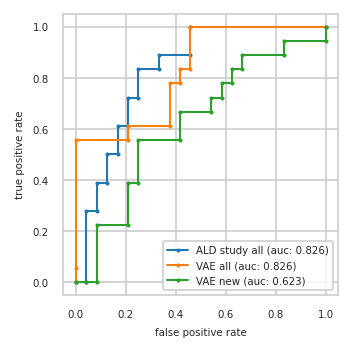

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.278   0.000 0.556   0.083 0.000
3          0.083 0.278   0.208 0.556   0.083 0.222
4          0.083 0.389   0.208 0.611   0.208 0.222
5          0.125 0.389   0.375 0.611   0.208 0.389
6          0.125 0.500   0.375 0.778   0.250 0.389
7          0.167 0.500   0.417 0.778   0.250 0.556
8          0.167 0.611   0.417 0.833   0.417 0.556
9          0.208 0.611   0.458 0.833   0.417 0.667
10         0.208 0.722   0.458 1.000   0.542 0.667
11         0.250 0.722   1.000 1.000   0.542 0.722
12         0.250 0.833     NaN   NaN   0.583 0.722
13         0.333 0.833     NaN   NaN   0.583 0.778
14         0.333 0.889     NaN   NaN   0.625 0.778
15         0.458 0.889     NaN   NaN   0.625 0.833
16         0.458 1.000     NaN   NaN   0.667 0.833
17         1.000 1.000     NaN   NaN   0.667 0.889
18           NaN   NaN     NaN   NaN   0.833 0.889
19           NaN   NaN     NaN   NaN   0.833 0.944
20           NaN   NaN     NaN   NaN   1.000 0.944
21           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NCL4,I3L3E6;Q658N2,H0Y7T8;P49418;P49418-2
2,P01701,P08253,Q9NUQ9
3,Q02818,P04075,P31321
4,P61981,P14174,Q96GD0
5,P04075,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P14174,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,P00338;P00338-3,P61981,P31150
8,Q9Y2T3;Q9Y2T3-3,P15151-2,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


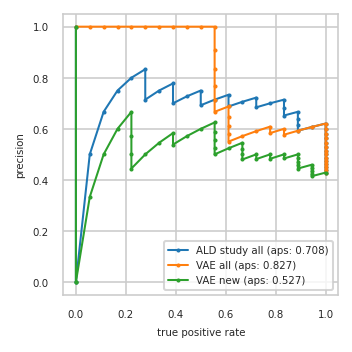

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.415 0.944
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.600 1.000     0.500 0.833
13         0.621 1.000     0.621 1.000     0.483 0.778
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.593 0.889     0.593 0.889     0.481 0.722
16         0.615 0.889     0.577 0.833     0.500 0.722
17         0.640 0.889     0.600 0.833     0.480 0.667
18         0.667 0.889     0.583 0.778     0.500 0.667
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.571 0.667     0.524 0.611
22         0.700 0.778     0.550 0.611     0.500 0.556
23         0.684 0.722     0.579 0.611     0.526 0.556
24         0.722 0.722     0.611 0.611     0.556 0.556
25         0.706 0.667     0.647 0.611     0.588 0.556
26         0.688 0.611     0.688 0.611     0.625 0.556
27         0.733 0.611     0.667 0.556     0.600 0.500
28         0.714 0.556     0.714 0.556     0.571 0.444
29         0.692 0.500     0.769 0.556     0.538 0.389
30         0.750 0.500     0.833 0.556     0.583 0.389
31         0.727 0.444     0.909 0.556     0.545 0.333
32         0.700 0.389     1.000 0.556     0.500 0.278
33         0.778 0.389     1.000 0.500     0.444 0.222
34         0.750 0.333     1.000 0.444     0.500 0.222
35         0.714 0.278     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


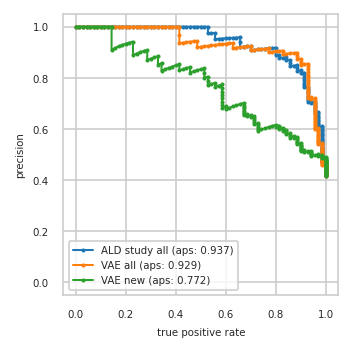

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


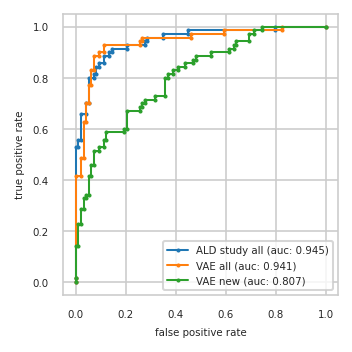

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}